国土地理院の浸水域JSONから標高ラスターを生成。パラメータ調整可能。（必要手続き：Driveの接続）

JSONはダウンロードしてケース名のディレクトリに保存
./PLATEAU-FloodSAR/ケース名/

ケース名は衛星解析のものとは別にすること。（コンタミ防止）


In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title パラメータの設定
casename = "omuta-r2"

mindepth = 0.05 # assume minimal depth of water to be detected
maxdem = 300 # maximum dem assumed for water surface. set something unrealy high.

flag_renew = False # Set True if flood_pts.pkl has been updated.

flood_json = "shinsui_rinkaku_omutashi.geojson"# ケースディレクトリ内のファイル名のみ。次のブロックにてフルパスに変換されます。

flg_display = False

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # True：図をGoogleドライブに保存する

zoomlevel = 15 # DEM zoom level to fetch
wall_height = 1000

analysis_tilesize = 4

errordem = -1000

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
file_bbox = path_case + "boundbox.npy"
file_fldbbox = path_case + "floodprb_bbox.npy"

file_flooddem = path_case + "flood_dem_{0:04d}.npz"
print(file_flooddem)
file_flooddepth = path_case + "flood_depth_{0:04d}.npz"

# 標高データの基本パラメータ
demtile_len = 256

flood_json = path_case + flood_json

/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/omuta-r2/flood_dem_{0:04d}.npz


In [ ]:
# @title 主要ライブラリインポート
!pip install --upgrade numpy
!pip install --upgrade scikit-image
!pip install rasterio
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import requests
import os
from scipy import ndimage as ndi
import matplotlib.patches as patches
from shapely.geometry import shape, mapping
import rasterio
from rasterio.features import geometry_mask
from affine import Affine
from skimage import measure
import json
from progressbar import progressbar
from shapely import box, Polygon
import sys
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 61.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 20.4 MB/s eta 0:00:00


In [ ]:
# @title 領域の読み込み
boundbox = np.load(file_bbox)
print(boundbox)

[130.38311   32.991771 130.545845  33.103334]


## 国土地理院の標高データの取得

In [ ]:
# @title DEMマップ取得
print(boundbox)
bbox = box(*boundbox)
print(bbox)
gdm = pfsl.GiajDemManager(path_home,dem_types = [{"type":"dem5a","z":15},{"type":"dem5b","z":15}])


[130.38311   32.991771 130.545845  33.103334]
POLYGON ((130.545845 32.991771, 130.545845 33.103334, 130.38311 33.103334, 130.38311 32.991771, 130.545845 32.991771))


In [ ]:
gdm.load_dem_tiles(bbox)
tile = gdm.produce_tile_stiched()
lons = tile["lons"]
lats = tile["lats"]
demmap = tile["dem"]

100% (16 of 16) |########################| Elapsed Time: 0:01:57 Time:  0:01:57


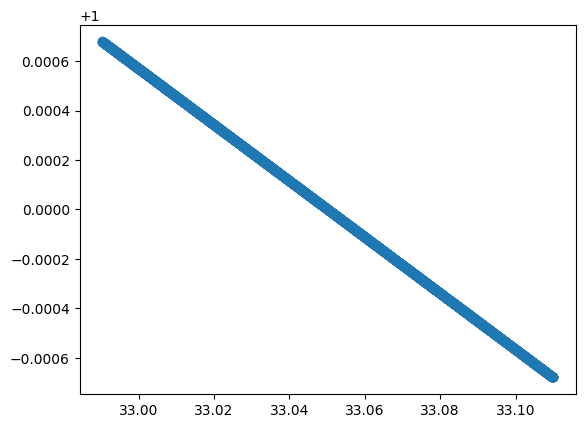

In [ ]:
dy = np.mean(lats[:-1]-lats[1:])
ax=plt.subplots()
plt.scatter(lats[:-1], (lats[:-1]-lats[1:])/dy)

In [ ]:
np.save(file_fldbbox , boundbox)

In [ ]:
minx = np.min(lons)
maxx = np.max(lons)
miny = np.min(lats)
maxy = np.max(lats)
print(boundbox)
print([minx, miny, maxx, maxy])

[130.38311   32.991771 130.545845  33.103334]
[130.374755859375, 32.990271555462655, 130.55049419403076, 33.10994829789429]


In [ ]:
with open(flood_json, "r") as f:
  geojson = json.load(f)
for feature in geojson["features"]:
  for ply in feature["geometry"]["coordinates"]:
    for cc in ply:
      cc[0] = pfsl.calc_floatIdx_of_list(cc[0],lons)
      cc[1] = pfsl.calc_floatIdx_of_list(cc[1],lats)
raster_height, raster_width = demmap.shape

binarymap = np.zeros_like(demmap)

for feature in progressbar(geojson["features"]):
  mask = geometry_mask([feature["geometry"]],
                      transform=Affine.identity(),
                      invert=True,
                      out_shape=(raster_height, raster_width))
  binarymap[mask] = 1


100% (66 of 66) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


In [ ]:
print(np.shape(binarymap))
print(len(lons), len(lats))

(3328, 4096)
4096 3328


(130.374755859375, 130.55049419403076, 32.990271555462655, 33.10994829789429)

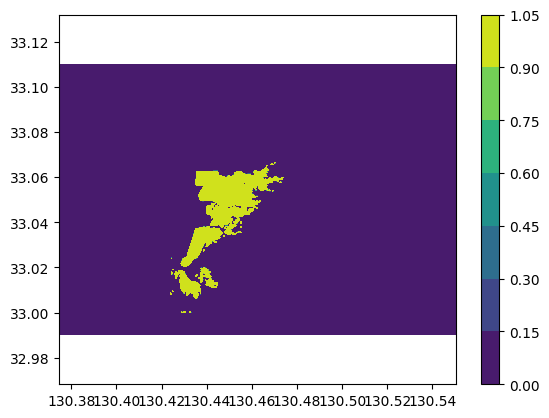

In [ ]:
ax = plt.subplot()
bndcp = np.array(binarymap, dtype=float)
img = plt.contourf(lons,lats,bndcp)#,extent=[minx, maxx, miny, maxy])
plt.colorbar()
ax.axis('equal')

In [ ]:
bndmap = measure.label(binarymap, connectivity=1, background=0)

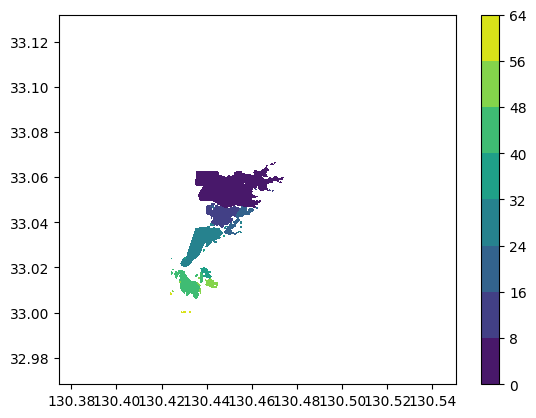

In [ ]:
if True: #flg_display:
  ax = plt.subplot()
  bndcp = np.array(bndmap, dtype=float)
  bndcp[bndcp==0.0] = np.nan
  img = plt.contourf(lons,lats,bndcp)
  plt.colorbar()
  ax.axis('equal')

In [ ]:
print( np.logical_and(2<np.arange(10), np.arange(10) < 5))

[False False False  True  True False False False False False]


In [ ]:
if flg_display:
  ax = plt.subplot()
  for ii in np.arange(1, np.max(bndmap)+1):
    tmplist = demmap[bndmap==ii]
    tmplist = tmplist[~np.isnan(tmplist)]
    lq = np.quantile(tmplist, 0.25)
    hq = np.quantile(tmplist, 0.75)
    lb = lq - 1.5 * (hq - lq)
    hb = hq + 1.5 * (hq - lq)
    inlist = tmplist[np.logical_and(lb<=tmplist,tmplist<=hb)]
    outlist = tmplist[np.logical_or(tmplist<lb,hb<tmplist)]
    #print(len(inlist), len(outlist))
    ax.scatter(np.ones_like(inlist)*ii, inlist, c="k", s=1, marker="o")
    ax.scatter(np.ones_like(outlist)*ii, outlist, c="c",s=1, marker="x")

In [ ]:
wtrdemmap = np.zeros_like(demmap)
wtrdemmap[bndmap==0] = np.nan
for ii in progressbar(np.arange(1, np.max(bndmap)+1)):
  tmplist = demmap[bndmap==ii]
  tmplist = tmplist[~np.isnan(tmplist)]
  lq = np.quantile(tmplist, 0.25)
  hq = np.quantile(tmplist, 0.75)
  hb = hq + 1.5 * (hq - lq)
  inlist = tmplist[tmplist<=hb]
  maxdem = np.nanmax(inlist)
  wtrdemmap[bndmap==ii] = maxdem

100% (59 of 59) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


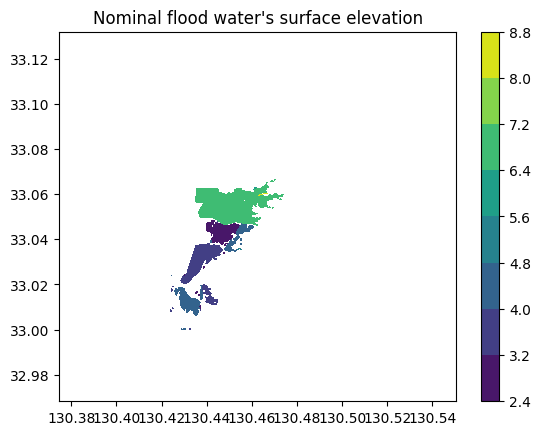

In [ ]:
if True: #flg_display:
  ax = plt.subplot()
  img = plt.contourf(lons,lats,wtrdemmap)
  plt.colorbar()
  plt.title("Nominal flood water's surface elevation")
  ax.axis('equal')

In [ ]:
wtrdpthmap = wtrdemmap-demmap

In [ ]:
print(f"{len(np.where(wtrdpthmap < 0)[0])} pxs are removed from {len(np.where(~np.isnan(wtrdpthmap))[0])} pxs")

1555 pxs are removed from 426325 pxs


In [ ]:
wtrdemmap[wtrdpthmap < 0] = np.nan
wtrdpthmap[wtrdpthmap < 0] = np.nan


In [ ]:
maxdepth = 0 # np.nanmax(combined_mask-demmap)

In [ ]:
np.savez(file_flooddem.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_dem=wtrdemmap)
np.savez(file_flooddepth.format(int(maxdepth*100)), lons=lons, lats=lats, floodmap_depth=wtrdpthmap)